# Load Data

First, load the csv data for angle and coordinate of the spiral vector field. 

In [97]:
import pandas as pd
from pathlib import Path
file_name = 'Front_EE-1_1_3000x_rings_coords.csv'
# csv_file = Path('/Users/rishabhkumar/spiral-chirals/vf_exports/Front_EE-1_1_3000x_rings_coords.csv')
csv_file = Path.cwd() / 'vf_exports' / file_name
with open(csv_file, 'r') as f:
    df = pd.read_csv(f)

print(df.head())
# remove the last row 
df = df.iloc[:-75]
# Try to find any .xlsx in the current working directory
# xlsx_files = list(Path('.').glob('*.xlsx'))

# if not xlsx_files:
#     raise FileNotFoundError(
#         "No .xlsx files found in the current directory. "
#         "Set `xlsx_path` to the file you want to load."
#     )

# # If multiple files found, pick the first one (adjust if you want a specific file)
# xlsx_path = xlsx_files[0]
# print(f"Loading Excel file: {xlsx_path}")

# # Read the first sheet into a dataframe
# df = pd.read_excel(xlsx_path, engine='openpyxl')

# # Quick inspection
# print("DataFrame shape:", df.shape)
# display(df.head())
# df.info()


  Ring     Coordinate  Angle (α′)        Pattern
0    1   (7.00, 0.00)      -26.09      Clockwise
1    1  (0.00, -7.00)       58.86  Anticlockwise
2    1  (-7.00, 0.00)      -31.99      Clockwise
3    1   (0.00, 7.00)       73.30  Anticlockwise
4    2  (43.00, 0.00)      -11.86      Clockwise


In [98]:
df

,Ring,Coordinate,Angle (α′),Pattern
0,1,"(7.00, 0.00)",-26.09,Clockwise
1,1,"(0.00, -7.00)",58.86,Anticlockwise
2,1,"(-7.00, 0.00)",-31.99,Clockwise
3,1,"(0.00, 7.00)",73.30,Anticlockwise
4,2,"(43.00, 0.00)",-11.86,Clockwise
...,...,...,...,...
89,7,"(97.00, -201.00)",68.08,Anticlockwise
90,7,"(50.00, -217.00)",-4.37,Clockwise
91,7,"(0.00, -223.00)",-29.24,Clockwise
92,7,"(-50.00, -217.00)",-34.25,Clockwise


In [99]:
# helper functions 
import ast

def parse_coord(s):
    if isinstance(s, (list, tuple, np.ndarray)):
        return list(s)
    if not isinstance(s, str):
        return [np.nan, np.nan]
    s = s.strip()
    try:
        val = ast.literal_eval(s)          # handles "(7.00, 0.00)" or "[7.00, 0.00]"
        return list(val)
    except Exception:
        parts = [p.strip() for p in s.strip("()[]").split(",")]
        try:
            return [float(parts[0]), float(parts[1])]
        except Exception:
            return [np.nan, np.nan]

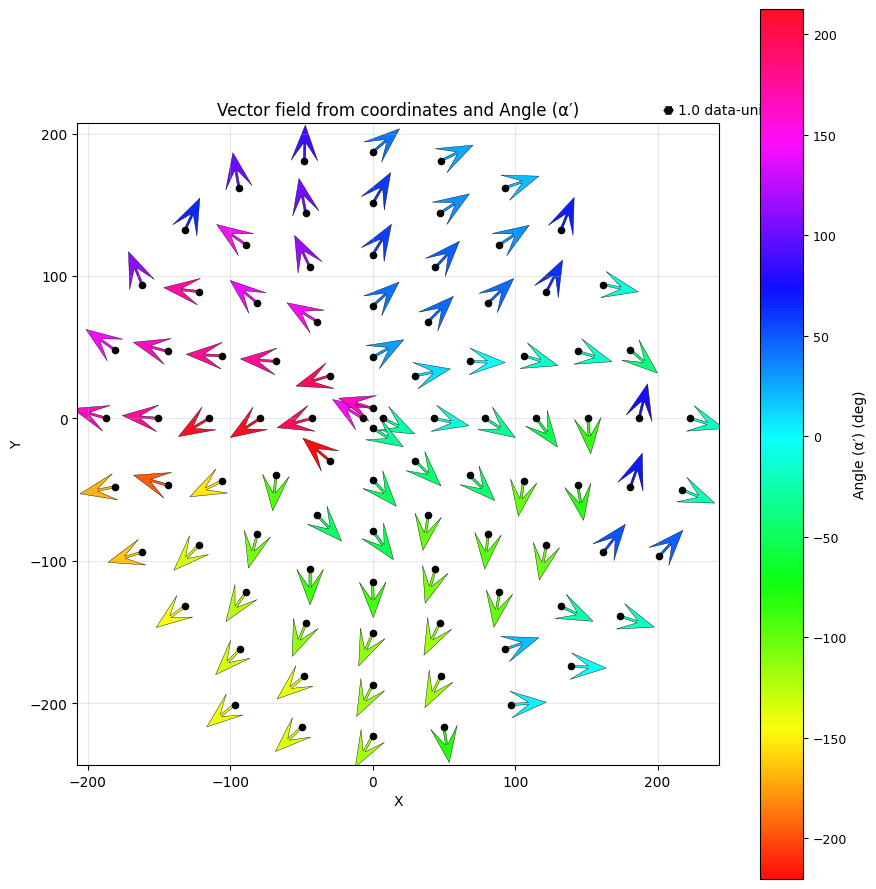

In [105]:
import matplotlib.pyplot as plt
import numpy as np
# Extract angles and filter valid data
angles_deg = df['Angle (α′)'].values 

# df['Coordinate'] = df['Coordinate'].apply(lambda x: np.array(x))    
coordinates = df['Coordinate'].apply(parse_coord).tolist()
# Find global theta from the coordinates 



# For these angles and coordinates, plot a vector field
X = [coord[0] for coord in coordinates]
Y = [coord[1] for coord in coordinates]
r = np.sqrt(np.array(X)**2 + np.array(Y)**2)
theta = np.arctan2(
    np.array(Y),
    np.array(X)
)
phi = angles_deg + np.degrees(theta)
phi_rad = np.deg2rad(phi)
U_plot = np.cos(phi_rad)
V_plot = np.sin(phi_rad)
# Compute a reasonable scale factor for the quiver key
scale_factor = np.round(np.percentile(np.sqrt(U_plot**2 + V_plot**2), 75), 1)
if scale_factor == 0:
    scale_factor = 1.0
# Create the plot
plt.figure(figsize=(9, 9))
magnitude_scale = 25.0
U_plot_scaled = magnitude_scale * U_plot
V_plot_scaled = magnitude_scale * V_plot
q = plt.quiver(
    X, Y, U_plot_scaled, V_plot_scaled, phi,
    angles='xy', scale_units='xy', scale=1, cmap='hsv',
    width=0.015,
    headwidth=12,
    headlength=16,
    headaxislength=8,
    alpha=0.95, edgecolor='k', linewidth=0.3
)
plt.scatter(X, Y, c='k', s=20, zorder=3)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Vector field from coordinates and Angle (α′)')
cbar = plt.colorbar(q, label='Angle (α′) (deg)')
cbar.ax.tick_params(labelsize=9)
plt.quiverkey(q, X=0.92, Y=1.02, U=scale_factor,
              label=f'{scale_factor} data-units', labelpos='E',
              fontproperties={'size':10})
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('vector_field_plot.svg', dpi=300)
plt.show()

## Cost function 

$\min_{\alpha'} \Sigma_{i = 1}^{n} d^2(\alpha'(x_i, y_i), \arctan(\frac{\pi}{2} - \alpha'))$
Suppose, we are in the polar coordinate system, $r = \cos \theta + i \sin \theta$
- Log spiral: $r = a \exp(k \theta)$, $$\cot(\alpha') = k$$
- Fermat spiral: $r = a \sqrt{\theta}$ $$\cot(\alpha') = \frac{a^2}{2 r^2}$$
- Archimedean spiral: $r = b \theta$  $$\cot(\alpha') = \frac{b}{r}$$

Use $d(x, y)$ as
- $d(x, y) = \sin(x - y)$
- $d(x, y) = |x - y|$, 
where $x, y \in (-\pi, \pi)$

Questions: 
1. Can we get explicit solutions to the minimization problem for any of these six cases? 
2. If not, do we use grid search to optimize or some gradient method? 

## Case 1: Log Spiral vector field

Suppose our vector fields have a log spiral shape. Then, the minimization problem is 
1. $\min_{k} \Sigma_{i = 1}^{n} ||\alpha'(x_i, y_i) - k||^2$
2. $\min_{k} \Sigma_{i = 1}^{n} \sin^2 (\alpha'(x_i, y_i) - k)$


In [114]:
## Solve the least squares problem to fit spirals
from scipy.optimize import minimize
def objective_log_spiral(k, angles, r, scaling = True):
    if scaling:
        residuals = 1/r * (angles - k)
    else:
        residuals = angles - k
    return np.sum(residuals**2)

def objective_log_spiral_sin(k, angles, r):
    residuals = np.sin(np.deg2rad(angles - k))
    return np.sum(residuals**2)

# Initial guess for k
k0 = 2.0
# Optimize using the first objective function
result1 = minimize(objective_log_spiral, k0, args=(angles_deg, r))
k_opt1 = result1.x[0]
# Optimize using the second objective function
result2 = minimize(objective_log_spiral_sin, k0, args=(angles_deg, r))
k_opt2 = result2.x[0]

print(f"Optimized k (least squares): {k_opt1:.4f} degrees")
print(f"Optimized k (sin squared): {k_opt2:.4f} degrees")
print(result1)
print(result2)

Optimized k (least squares): 15.9105 degrees
Optimized k (sin squared): -17.5133 degrees
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 209.39652237389987
        x: [ 1.591e+01]
      nit: 3
      jac: [ 3.815e-06]
 hess_inv: [[ 5.499e+00]]
     nfev: 10
     njev: 5
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 29.546946394661656
        x: [-1.751e+01]
      nit: 4
      jac: [-4.768e-07]
 hess_inv: [[ 4.705e+01]]
     nfev: 14
     njev: 7


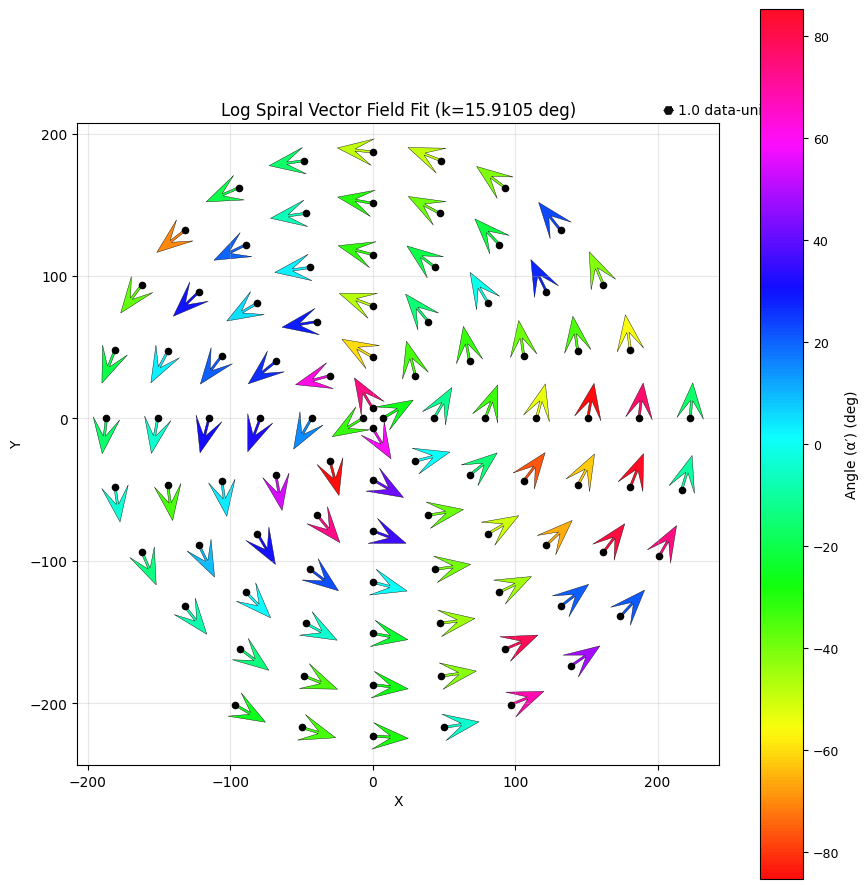

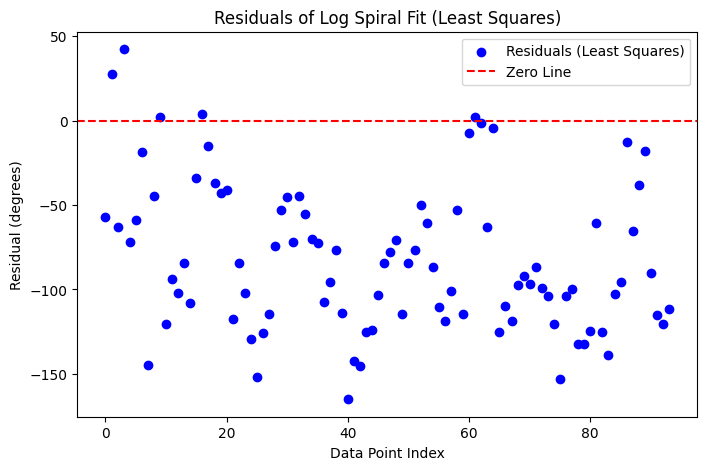

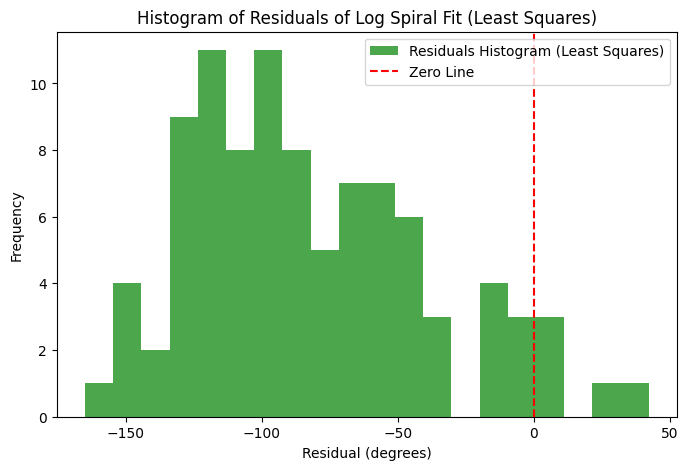

In [115]:
# Plotting log spiral vector field with above parameters (k_opt1 and k_opt2)
def log_spiral_vector_field(x, y, k):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    alpha_prime = k * np.log(r + 1e-8)  # add small value to avoid log(0)
    phi = theta + np.deg2rad(alpha_prime)
    Vx = np.cos(phi)
    Vy = np.sin(phi)
    return Vx, Vy

Vx1, Vy1 = log_spiral_vector_field(np.array(X), np.array(Y), k_opt1)
Vx2, Vy2 = log_spiral_vector_field(np.array(X), np.array(Y), k_opt2)
# Plotting
plt.figure(figsize=(9, 9))
magnitude_scale = 25.0
U1_scaled = magnitude_scale * Vx1
V1_scaled = magnitude_scale * Vy1
U2_scaled = magnitude_scale * Vx2
V2_scaled = magnitude_scale * Vy2

q1 = plt.quiver(
    X, Y, U1_scaled, V1_scaled, angles_deg,
    angles='xy', scale_units='xy', scale=1, cmap='hsv',
    width=0.015,
    headwidth=12,
    headlength=16,
    headaxislength=8,
    alpha=0.95, edgecolor='k', linewidth=0.3
)

plt.scatter(X, Y, c='k', s=20, zorder=3)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Log Spiral Vector Field Fit (k={k_opt1:.4f} deg)')
cbar = plt.colorbar(q1, label='Angle (α′) (deg)')
cbar.ax.tick_params(labelsize=9)
plt.quiverkey(q1, X=0.92, Y=1.02, U=scale_factor,
              label=f'{scale_factor} data-units', labelpos='E',
              fontproperties={'size':10})
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('log_spiral_vector_field_fit.svg', dpi=300)
plt.show()

## Plot residuals 
predicted_angles = k_opt1 * np.log(r + 1e-8)
residuals1 = angles_deg - predicted_angles

plt.figure(figsize=(8, 5))
plt.scatter(range(len(residuals1)), residuals1, color='blue', label='Residuals (Least Squares)')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Data Point Index')
plt.ylabel('Residual (degrees)')
plt.title('Residuals of Log Spiral Fit (Least Squares)')
plt.legend()

plt.figure(figsize=(8, 5))
plt.hist(residuals1, bins=20, color='green', alpha=0.7, label='Residuals Histogram (Least Squares)')
plt.axvline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Residual (degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of Log Spiral Fit (Least Squares)')
plt.legend()
plt.show()

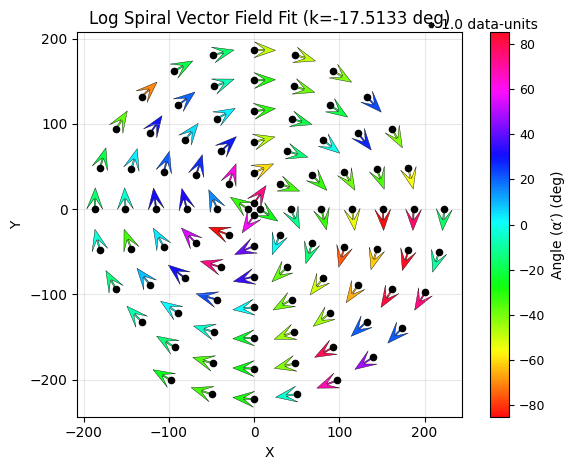

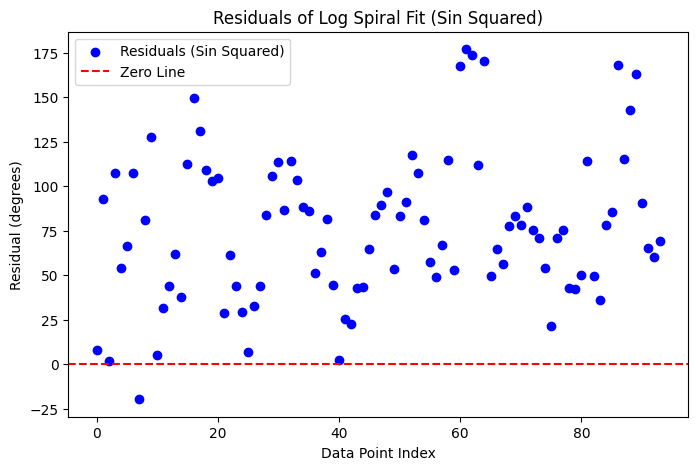

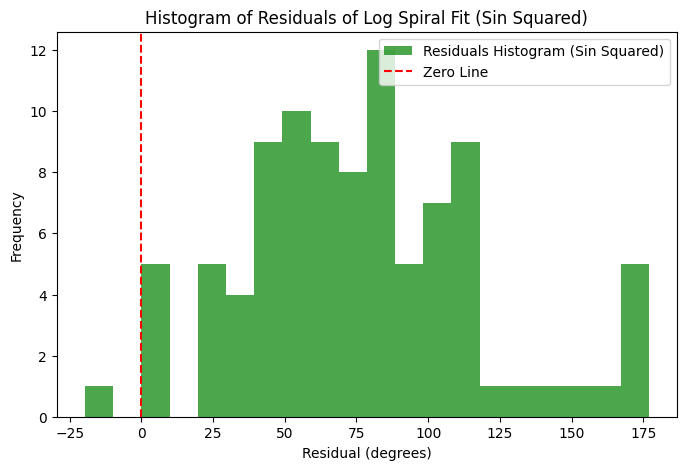

In [116]:
q2 = plt.quiver(
    X, Y, U2_scaled, V2_scaled, angles_deg,
    angles='xy', scale_units='xy', scale=1, cmap='hsv',
    width=0.015,
    headwidth=12,
    headlength=16,
    headaxislength=8,
    alpha=0.95, edgecolor='k', linewidth=0.3
)

plt.scatter(X, Y, c='k', s=20, zorder=3)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Log Spiral Vector Field Fit (k={k_opt2:.4f} deg)')
cbar = plt.colorbar(q2, label='Angle (α′) (deg)')
cbar.ax.tick_params(labelsize=9)
plt.quiverkey(q2, X=0.92, Y=1.02, U=scale_factor,
              label=f'{scale_factor} data-units', labelpos='E',
              fontproperties={'size':10})
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('log_spiral_vector_field_fit_sin.svg', dpi=300)
plt.show()

## Plot residuals
residuals2 = angles_deg - (k_opt2 * np.log(r + 1e-8))
plt.figure(figsize=(8, 5))
plt.scatter(range(len(residuals2)), residuals2, color='blue', label='Residuals (Sin Squared)')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Data Point Index')
plt.ylabel('Residual (degrees)')
plt.title('Residuals of Log Spiral Fit (Sin Squared)')
plt.legend()
plt.figure(figsize=(8, 5))
plt.hist(residuals2, bins=20, color='green', alpha=0.7, label='Residuals Histogram (Sin Squared)')
plt.axvline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Residual (degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of Log Spiral Fit (Sin Squared)')
plt.legend()
plt.show()


## Case 2: Fermat spiral vector field 
1. $\min_{k} \Sigma_{i = 1}^{n} ||\alpha'(x_i, y_i) - \arctan(2 \frac{r_i^2}{a^2})||^2$
2. $\min_{k} \Sigma_{i = 1}^{n} \sin^2 (\alpha'(x_i, y_i) - \arctan(2 \frac{r_i^2}{a^2}))$


Fermat spiral (polar): $r = a\sqrt{\theta}$, with $ a>0, \theta \ge 0$ .

Pitch angle:
$$
\cot \alpha'(r) = \frac{1}{r}\frac{dr}{d\theta} = \frac{a^2}{2r^2}
\;\;\Rightarrow\;\;
\alpha'(r) = \arctan\!\left(\frac{2r^2}{a^2}\right).
$$

Vector field as unit tangent (polar):

$$\phi(r,\theta) = \theta + \alpha'(r),\qquad
\mathbf{v}(r,\theta) = \big(\cos\phi,\; \sin\phi\big).$$


Cartesian form, with $r=\sqrt{x^2+y^2}$ and $\theta=\operatorname{atan2}(y,x)$ :

$$\mathbf{V}(x,y) =
\begin{pmatrix}
\cos\!\left(\operatorname{atan2}(y,x) + \arctan\!\Big(\frac{2(x^2+y^2)}{a^2}\Big)\right) \\
\sin\!\left(\operatorname{atan2}(y,x) + \arctan\!\Big(\frac{2(x^2+y^2)}{a^2}\Big)\right)
\end{pmatrix}.
$$



In [117]:
# plot the vector field with the fitted spirals and their residuals
from scipy.optimize import minimize
# Fermat spiral (polar): $r = a\sqrt{\theta}$, with $ a>0, \theta \ge 0$ .

def objective_fermat_spiral(a, angles, r, scaling = True):
    predicted_angles = np.degrees(np.arctan(2 * r**2 / a**2))
    if scaling:
        residuals = 1/r * (angles - predicted_angles)
    else:
        residuals = angles - predicted_angles
    return np.sum(residuals**2)

def objective_fermat_spiral_sin(a, angles, r):
    predicted_angles = np.degrees(np.arctan(2 * r**2 / a**2))
    residuals = np.sin(np.deg2rad(angles - predicted_angles))
    return np.sum(residuals**2)

# Initial guess for a
a0 = 0.1
# Optimize using the objective function
result3 = minimize(objective_fermat_spiral, a0, args=(angles_deg, r))
a_opt1 = result3.x[0]
# Optimize using the sin squared objective function
result4 = minimize(objective_fermat_spiral_sin, a0, args=(angles_deg, r))
a_opt2 = result4.x[0]

print(f"Optimized a (least squares): {a_opt1:.4f}")
print(f"Optimized a (sin squared): {a_opt2:.4f}")
print(result3)
print(result4)




Optimized a (least squares): 18.1569
Optimized a (sin squared): 0.0001
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 286.5873585446935
        x: [ 1.816e+01]
      nit: 5
      jac: [-3.815e-06]
 hess_inv: [[ 2.666e+00]]
     nfev: 20
     njev: 10
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 61.292071871185236
        x: [ 1.343e-04]
      nit: 3
      jac: [ 9.537e-07]
 hess_inv: [[ 1.691e+02]]
     nfev: 12
     njev: 6


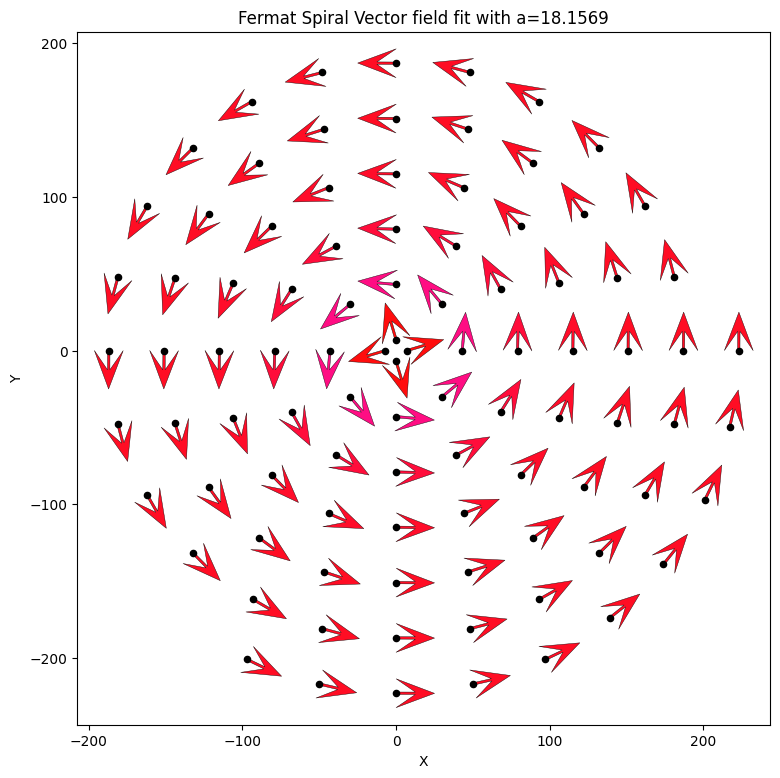

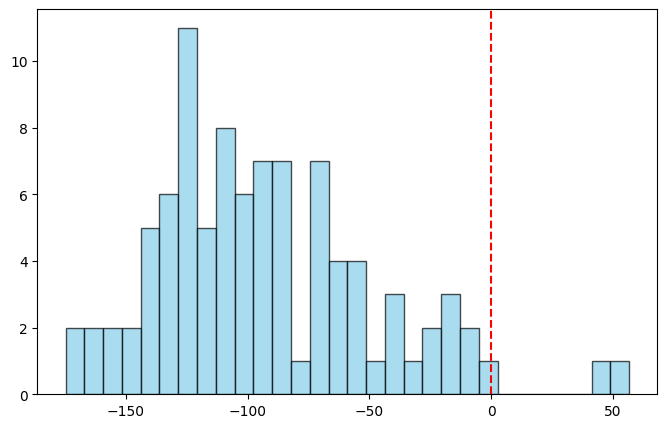

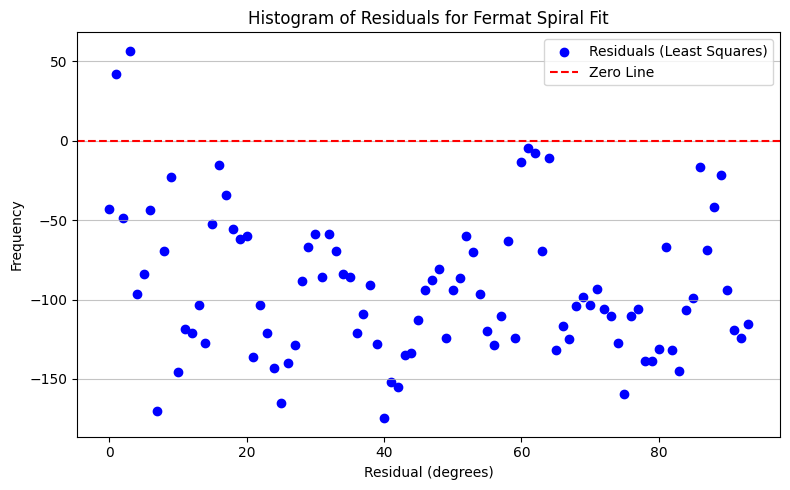

In [118]:
# Plot the vector field with the fitted spirals and their residuals
predicted_angles_fermat = np.degrees(np.arctan(2 * r**2 / a_opt1**2))
residuals_fermat = angles_deg - predicted_angles_fermat

# For each x_i, y_i coordinate, compute the predicted vector from the fitted spiral
for i in range(len(coordinates)):
    r_i = r[i]
    theta_i = theta[i]
    fitted_angle = predicted_angles_fermat[i]
    phi_fitted = fitted_angle + np.degrees(theta_i)
    phi_fitted_rad = np.deg2rad(phi_fitted)
    U_fitted = np.cos(phi_fitted_rad)
    V_fitted = np.sin(phi_fitted_rad)
    # You can store or plot these fitted vectors as needed

# Plotting the vector field with fitted Fermat spiral
plt.figure(figsize=(9, 9))
U_fitted_scaled = magnitude_scale * np.cos(np.deg2rad(predicted_angles_fermat + np.degrees(theta)))
V_fitted_scaled = magnitude_scale * np.sin(np.deg2rad(predicted_angles_fermat + np.degrees(theta)))
q_fitted = plt.quiver(
    X, Y, U_fitted_scaled, V_fitted_scaled, predicted_angles_fermat,
    angles='xy', scale_units='xy', scale=1, cmap='hsv',
    width=0.015,
    headwidth=12,
    headlength=16,
    headaxislength=8,
    alpha=0.95, edgecolor='k', linewidth=0.3
)

plt.scatter(X, Y, c='k', s=20, zorder=3)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Fermat Spiral Vector field fit with a={a_opt1:.4f}')

plt.show()

## Plot residuals histogram for Fermat spiral fit
plt.figure(figsize=(8, 5))
plt.hist(residuals_fermat, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Line')

plt.figure(figsize=(8, 5))
plt.scatter(range(len(residuals_fermat)), residuals_fermat, color='blue', label='Residuals (Least Squares)')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Data Point Index')
plt.ylabel('Residual (degrees)')
plt.title('Residuals of Fermat Spiral Fit (Least Squares)')
plt.legend()

plt.title('Histogram of Residuals for Fermat Spiral Fit')
plt.xlabel('Residual (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

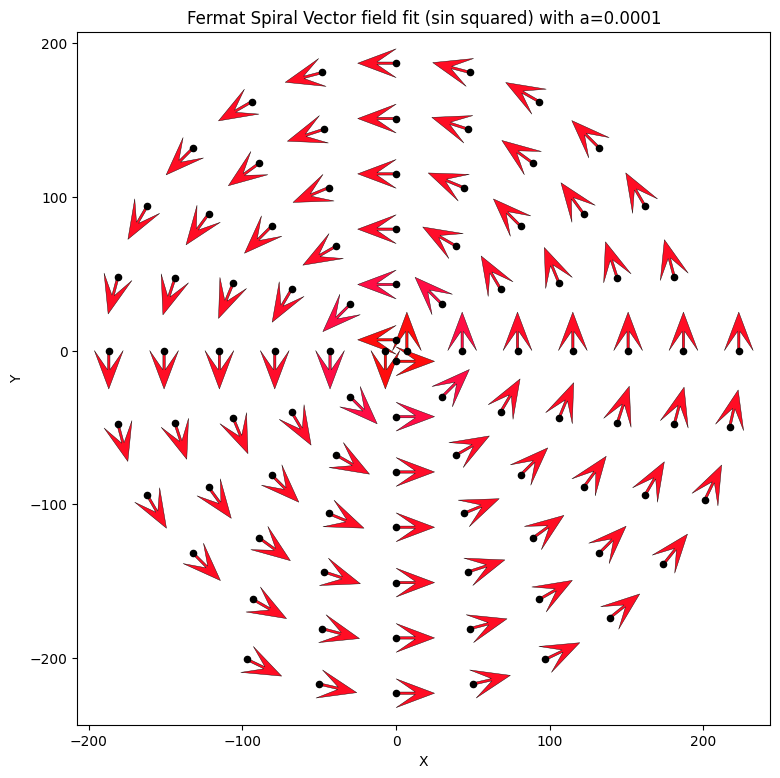

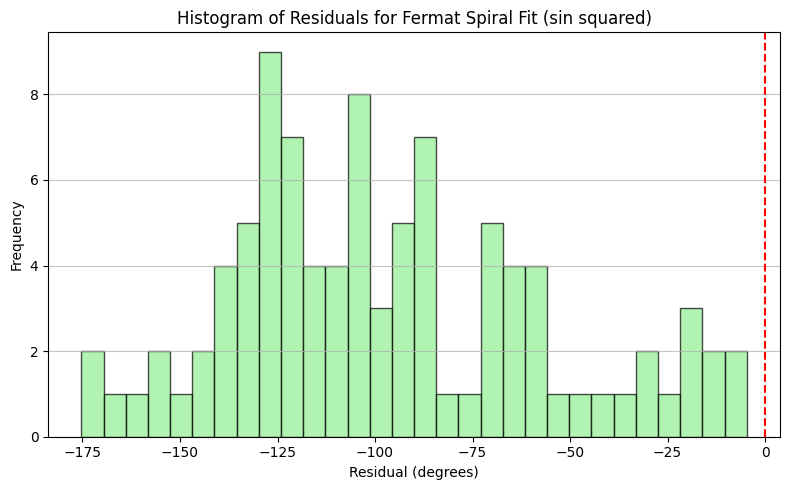

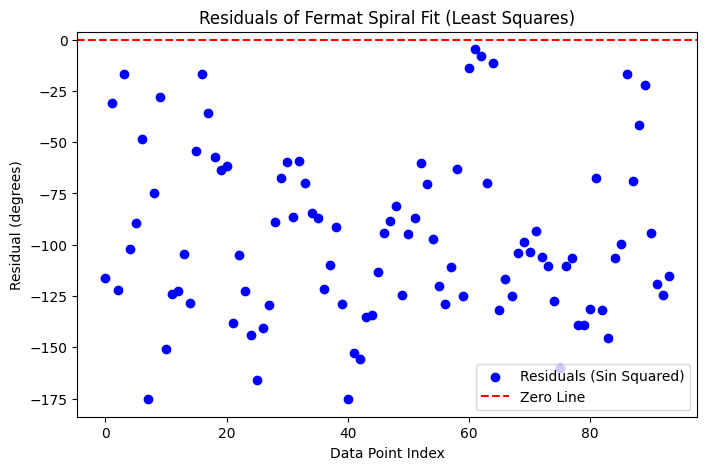

In [119]:
# Do the same for a_opt2
# Plotting the vector field with fitted Fermat spiral (sin squared)
plt.figure(figsize=(9, 9))
U_fitted_scaled2 = magnitude_scale * np.cos(np.deg2rad(np.degrees(np.arctan(2 * r**2 / a_opt2**2)) + np.degrees(theta)))
V_fitted_scaled2 = magnitude_scale * np.sin(np.deg2rad(np.degrees(np.arctan(2 * r**2 / a_opt2**2)) + np.degrees(theta)))
q_fitted2 = plt.quiver(
    X, Y, U_fitted_scaled2, V_fitted_scaled2, np.degrees(np.arctan(2 * r**2 / a_opt2**2)),
    angles='xy', scale_units='xy', scale=1, cmap='hsv',
    width=0.015,
    headwidth=12,
    headlength=16,
    headaxislength=8,
    alpha=0.95, edgecolor='k', linewidth=0.3
)
plt.scatter(X, Y, c='k', s=20, zorder=3)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Fermat Spiral Vector field fit (sin squared) with a={a_opt2:.4f}')
plt.show()

# Plot residuals histogram for Fermat spiral fit (sin squared)
predicted_angles_fermat2 = np.degrees(np.arctan(2 * r**2 / a_opt2**2))
residuals_fermat2 = angles_deg - predicted_angles_fermat2
plt.figure(figsize=(8, 5))
plt.hist(residuals_fermat2, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Line')

plt.title('Histogram of Residuals for Fermat Spiral Fit (sin squared)')
plt.xlabel('Residual (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(range(len(residuals_fermat2)), residuals_fermat2, color='blue', label='Residuals (Sin Squared)')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Data Point Index')
plt.ylabel('Residual (degrees)')
plt.title('Residuals of Fermat Spiral Fit (Least Squares)')
plt.legend()


## Case 3: Archimedean spiral vector field

1. $\min_{k} \Sigma_{i = 1}^{n} ||\alpha'(x_i, y_i) - \arctan(\frac{r_i}{b})||^2$
2. $\min_{k} \Sigma_{i = 1}^{n} \sin^2 (\alpha'(x_i, y_i) - \arctan(\frac{r_i}{b}))$

In [122]:
def objective_archimedean_spiral(b, angles, r, scaling = True):
    predicted_angles = np.degrees(np.arctan(r / b))

    if scaling:
        residuals = 1/r * (angles - predicted_angles)
    else:
        residuals = angles - predicted_angles
    # residuals = angles - predicted_angles
    return np.sum(residuals**2)

def objective_archimedean_spiral_sin(b, angles, r):
    predicted_angles = np.degrees(np.arctan(r / b))
    residuals = np.sin(np.deg2rad(angles - predicted_angles))
    return np.sum(residuals**2)

# Initial guess for b
b0 = 1.0
# Optimize using the objective function
result5 = minimize(objective_archimedean_spiral, b0, args=(angles_deg, r))
b_opt1 = result5.x[0]
# Optimize using the sin squared objective function
result6 = minimize(objective_archimedean_spiral_sin, b0, args=(angles_deg, r))
b_opt2 = result6.x[0]
print(f"Optimized b (least squares): {b_opt1:.4f}")
print(f"Optimized b (sin squared): {b_opt2:.4f}")
print(result5)
print(result6)

Optimized b (least squares): 1103.7998
Optimized b (sin squared): -455.6928
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 232.17252247413236
        x: [ 1.104e+03]
      nit: 26
      jac: [ 1.907e-06]
 hess_inv: [[ 2.584e+06]]
     nfev: 54
     njev: 27
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 29.03525048146255
        x: [-4.557e+02]
      nit: 8
      jac: [ 4.768e-07]
 hess_inv: [[ 3.081e+04]]
     nfev: 26
     njev: 13


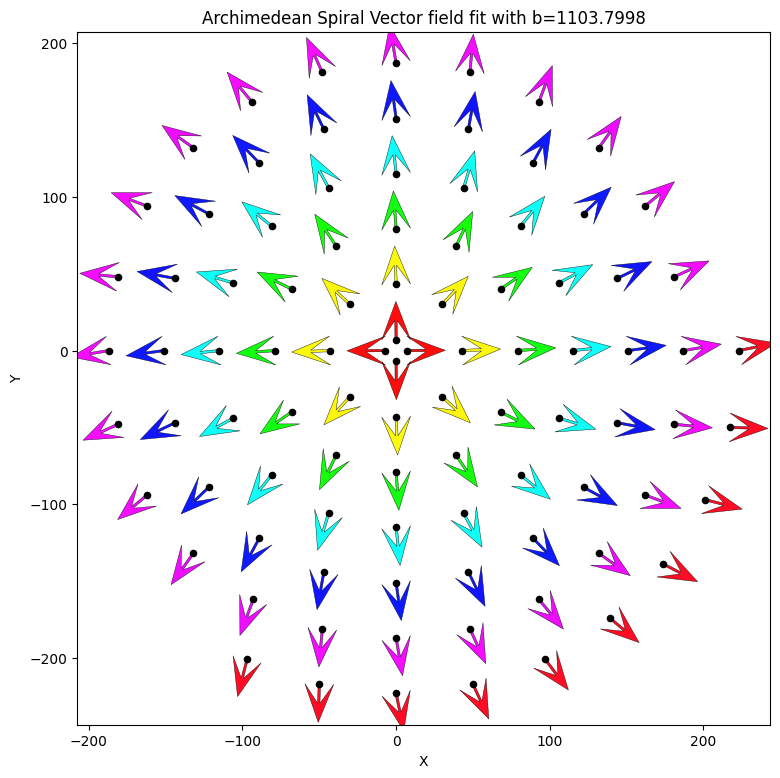

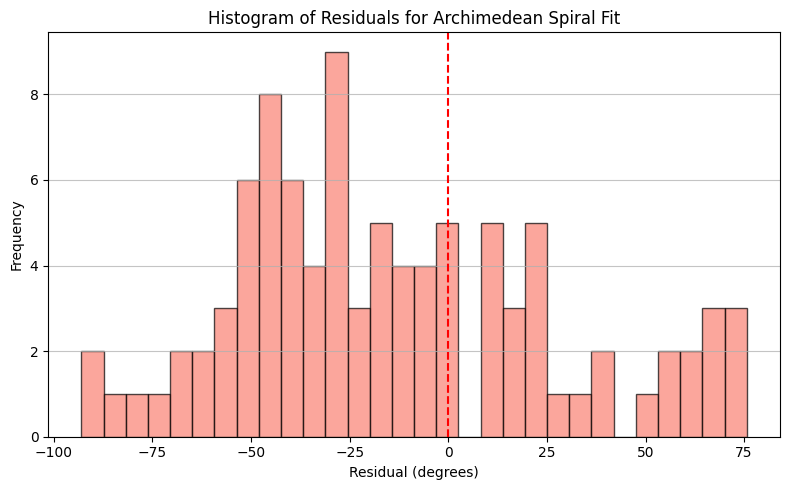

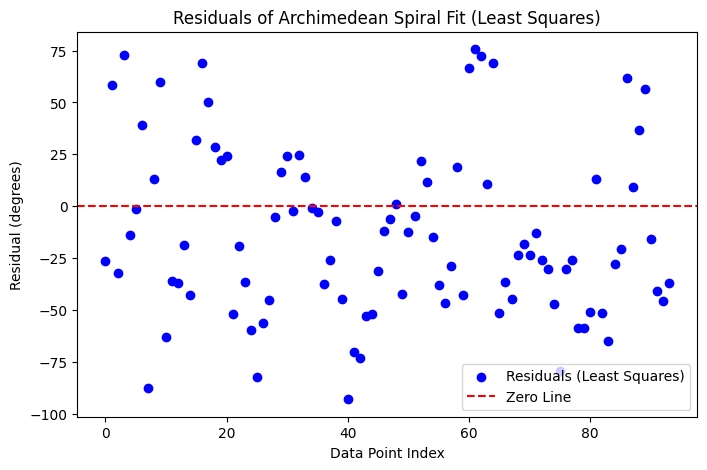

In [123]:
## Plot the vector field with the fitted Archimedean spirals and their residuals
predicted_angles_archimedean = np.degrees(np.arctan(r / b_opt1))
residuals_archimedean = angles_deg - predicted_angles_archimedean
# For each x_i, y_i coordinate, compute the predicted vector from the fitted spiral
for i in range(len(coordinates)):
    r_i = r[i]
    theta_i = theta[i]
    fitted_angle = predicted_angles_archimedean[i]
    phi_fitted = fitted_angle + np.degrees(theta_i)
    phi_fitted_rad = np.deg2rad(phi_fitted)
    U_fitted = np.cos(phi_fitted_rad)
    V_fitted = np.sin(phi_fitted_rad)

plt.figure(figsize=(9, 9))
U_fitted_scaled = magnitude_scale * np.cos(np.deg2rad(predicted_angles_archimedean + np.degrees(theta)))
V_fitted_scaled = magnitude_scale * np.sin(np.deg2rad(predicted_angles_archimedean + np.degrees(theta)))
q_fitted = plt.quiver(
    X, Y, U_fitted_scaled, V_fitted_scaled, predicted_angles_archimedean,
    angles='xy', scale_units='xy', scale=1, cmap='hsv',
    width=0.015,
    headwidth=12,
    headlength=16,
    headaxislength=8,
    alpha=0.95, edgecolor='k', linewidth=0.3
)   
plt.scatter(X, Y, c='k', s=20, zorder=3)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Archimedean Spiral Vector field fit with b={b_opt1:.4f}')
plt.show()

## Plot residuals histogram for Archimedean spiral fit
plt.figure(figsize=(8, 5))
plt.hist(residuals_archimedean, bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Line')

plt.title('Histogram of Residuals for Archimedean Spiral Fit')
plt.xlabel('Residual (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
plt.scatter(range(len(residuals_archimedean)), residuals_archimedean, color='blue', label='Residuals (Least Squares)')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Data Point Index')
plt.ylabel('Residual (degrees)')
plt.title('Residuals of Archimedean Spiral Fit (Least Squares)')
plt.legend()


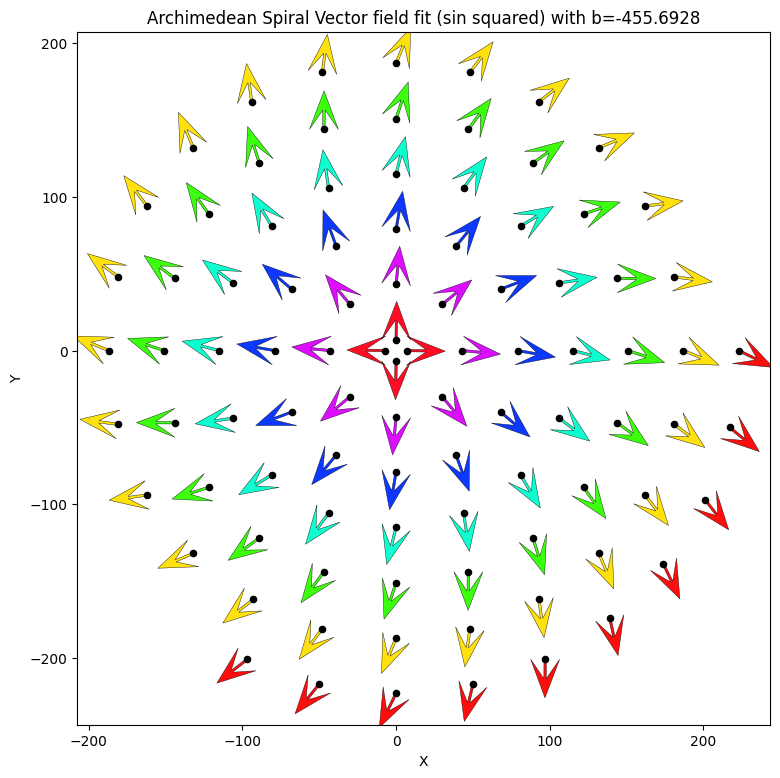

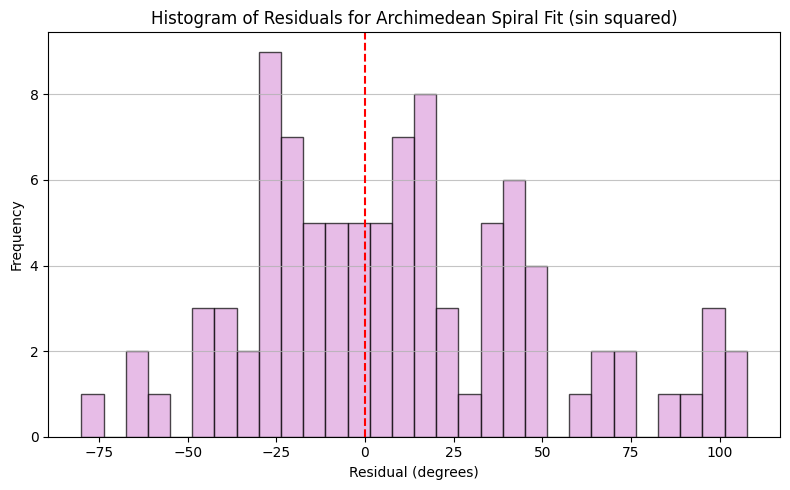

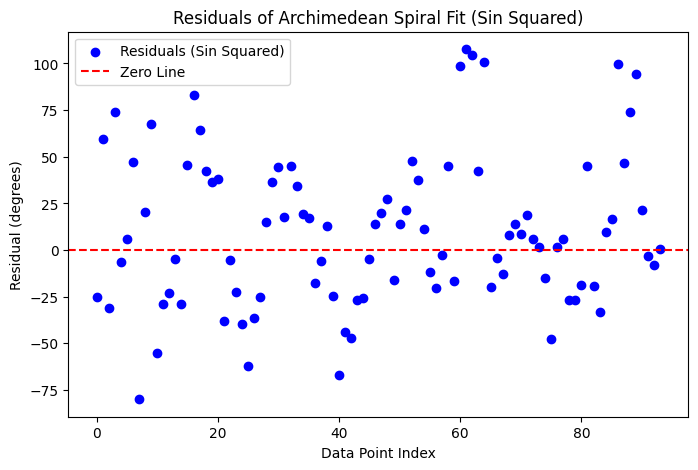

In [124]:
# Plot predicted vector field for Archimedean spiral (sin squared)
predicted_angles_archimedean2 = np.degrees(np.arctan(r / b_opt2))
residuals_archimedean2 = angles_deg - predicted_angles_archimedean2
plt.figure(figsize=(9, 9))
U_fitted_scaled2 = magnitude_scale * np.cos(np.deg2rad(predicted_angles_archimedean2 + np.degrees(theta)))
V_fitted_scaled2 = magnitude_scale * np.sin(np.deg2rad(predicted_angles_archimedean2 + np.degrees(theta)))
q_fitted2 = plt.quiver(
    X, Y, U_fitted_scaled2, V_fitted_scaled2, predicted_angles_archimedean2,
    angles='xy', scale_units='xy', scale=1, cmap='hsv',
    width=0.015,
    headwidth=12,
    headlength=16,
    headaxislength=8,
    alpha=0.95, edgecolor='k', linewidth=0.3
)
plt.scatter(X, Y, c='k', s=20, zorder=3)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Archimedean Spiral Vector field fit (sin squared) with b={b_opt2:.4f}')
plt.show()  

# plot residuals histogram for Archimedean spiral fit (sin squared)
plt.figure(figsize=(8, 5))
plt.hist(residuals_archimedean2, bins=30, color='plum', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Line')
plt.title('Histogram of Residuals for Archimedean Spiral Fit (sin squared)')
plt.xlabel('Residual (degrees)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
plt.scatter(range(len(residuals_archimedean2)), residuals_archimedean2, color='blue', label='Residuals (Sin Squared)')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Data Point Index')
plt.ylabel('Residual (degrees)')
plt.title('Residuals of Archimedean Spiral Fit (Sin Squared)')
plt.legend()
